In [36]:
import h5py
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import scipy as sp
import sys
from datetime import date
import mne 
sys.path.append("/home/aallawala/iEEG-GenFxns/Signal_proc")

In [55]:
## Plan for preprocessing: 

# 1. preprocess and wavelet each fif file, save timestamp with it
# 2. average PSD from each fif file and save it, along with timestamp in it 
# 3. load all files together 
# 4. find closest timestamp to each file from survey file (think about how to do this**)
# 5. run correlation.  

ptID = 'RCS04'

filepath = '/datastore_spirit/human/ChronicPain_NK/js_decoding/all_bipolar/%s/during_surv/fif/' % (ptID)
filename = '%s_924_eeg_raw.fif' % (ptID)
# filename = '%s_869_eeg_raw.fif' % (ptID)
fullfile = filepath + filename
print(fullfile)
raw = mne.io.read_raw_fif(fullfile)

/datastore_spirit/human/ChronicPain_NK/js_decoding/all_bipolar/RCS04/during_surv/fif/RCS04_924_eeg_raw.fif
Opening raw data file /datastore_spirit/human/ChronicPain_NK/js_decoding/all_bipolar/RCS04/during_surv/fif/RCS04_924_eeg_raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 3246 ... 33245 =      3.246 ...    33.245 secs
Ready.


In [64]:
data,times = raw[:]
rec_timestamp = raw.info['meas_date']
sfreq = raw.info['sfreq']
raw_ch_labels = raw.info['ch_names'][:]
n_ch = raw.info['nchan']
import re
tmp = re.findall(r'\d+', filename)
res = list(map(int, tmp))
fileid = res[1]

In [81]:
raw_ch_labels[0][4::]
tmp = raw_ch_labels[0]
modified_string = tmp.replace('POL ', '')
modified_string

'L ACC2-Ref-L ACC3-Ref'

In [83]:
# clean channel names 

remove_pol = lambda s: s.replace('POL ', '').replace('-Ref', '')

modified_list_for_loop = []
for s in raw_ch_labels:
    modified_list_for_loop.append(remove_pol(s))

print(modified_list_for_loop)

# Apply lambda function to each string in the list using list comprehension
ch_label = [remove_pol(s) for s in raw_ch_labels]

['L ACC2-L ACC3', 'L ACC3-L ACC4', 'L ACC4-L ACC5', 'L ACC5-L ACC6', 'L ACC6-L ACC7', 'L ACC7-L ACC8', 'L ACC8-L ACC9', 'L ACC9-L ACC10', 'L CMa1-L CMa2', 'L CMa2-L CMa3', 'L CMa3-L CMa4', 'L CMa4-L CMa5', 'L CMa5-L CMa6', 'L CMa6-L CMa7', 'L CMa7-L CMa8', 'L INS1-L INS2', 'L INS2-L INS3', 'L INS3-L INS4', 'L INS4-L INS5', 'L INS5-L INS6', 'L INS6-L INS7', 'L INS7-L INS8', 'L INS8-L INS9', 'L INS9-L INS10', 'L INS10-L INS11', 'L INS11-L INS12', 'L M1-L M2', 'L M2-L M3', 'L M3-L M4', 'L M4-L M5', 'L M5-L M6', 'L SGC1-L SGC2', 'L SGC2-L SGC3', 'L SGC3-L SGC4', 'L SGC4-L SGC5', 'L SGC5-L SGC6', 'L SGC6-L SGC7', 'L SGC7-L SGC8', 'L SGC8-L SGC9', 'L SGC9-L SGC10', 'L SGC10-L SGC11', 'R ACC1-R ACC2', 'R ACC2-R ACC3', 'R ACC3-R ACC4', 'R ACC4-R ACC5', 'R ACC5-R ACC6', 'R ACC6-R ACC7', 'R CMa1-R CMa2', 'R CMa2-R CMa3', 'R CMa3-R CMa4', 'R CMa4-R CMa5', 'R CMa5-R CMa6', 'R CMa6-R CMa7', 'R CMa7-R CMa8', 'R INS1-R INS2', 'R INS2-R INS3', 'R INS3-R INS4', 'R INS4-R INS5', 'R INS5-R INS6', 'R INS6

In [85]:
from preproc_fxns import butterworth_notch_filter

notch_freqs = [60, 120, 180, 240]
order = 4       # Example value, replace with the actual value

filt_data = butterworth_notch_filter(data.T,order, notch_freqs[0], sfreq, n_ch)
filt_data = butterworth_notch_filter(filt_data,order, notch_freqs[1], sfreq, n_ch)
filt_data = butterworth_notch_filter(filt_data,order, notch_freqs[2], sfreq, n_ch)
filt_data = butterworth_notch_filter(filt_data,order, notch_freqs[3], sfreq, n_ch)

In [113]:
# wavelet 
# num_frequencies = 50 #updated to capture more frequencies 03/22/24 
# min_freq = 1  # Hz
# max_freq = 250  # Hz

# freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frequencies)

# low_wave_num = [3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 10, 10, 11, 11, 12, 13, 14, 16, 16, 17, 17, 18, 18]
# high_wave_num = np.tile(18, (22, 1)).flatten()

# # wave_num = np.tile(6,reps=(50,1))
# wave_num = np.concatenate(arrays=(low_wave_num, high_wave_num))

num_frequencies = 40 #updated to capture more frequencies 03/22/24 
min_freq = 1  # Hz
max_freq = 130  # Hz

freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), num_frequencies)
# wave_num = [3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 10, 10, 11, 11, 12, 13, 14, 16, 16, 17, 17, 18, 18]


In [114]:
wave_num = [3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 10, 10, 10, 10, 11, 11, 12, 13, 14, 16, 16, 17, 17, 18, 18, 18, 18]
len(wave_num)

40

array([  1.        ,   1.13293156,   1.28353392,   1.45415609,
         1.64745933,   1.86645867,   2.11456994,   2.39566302,
         2.71412225,   3.07491476,   3.48366798,   3.94675741,
         4.47140603,   5.06579702,   5.73920133,   6.50212232,
         7.3664596 ,   8.34569457,   9.45510079,  10.7119821 ,
        12.13594261,  13.74919241,  15.57689403,  17.64755488,
        19.99347191,  22.65123535,  25.66229944,  29.07362898,
        32.93843188,  37.31698907,  42.2775947 ,  47.89762138,
        54.26472699,  61.47822189,  69.65061794,  78.90938335,
        89.3989309 , 101.28287039, 114.74656052, 130.        ])

In [110]:
freqs

array([  1.        ,   1.1975515 ,   1.43412959,   1.71744404,
         2.05672768,   2.46303731,   2.94961402,   3.53231469,
         4.23012875,   5.06579702,   6.06655281,   7.2650094 ,
         8.70022289,  10.41896495,  12.47724708,  14.94214593,
        17.89398924,  21.42897361,  25.66229944,  30.73192513,
        36.80306296,  44.07356317,  52.78036159,  63.20720107,
        75.6938783 ,  90.64731733, 108.55483063, 130.        ])

In [97]:

# # wavelet analysis 

def decomp_wavelet(data,freqs,srate,wave_num):
    from scipy.signal import convolve

    tmp_amplitude = np.zeros((len(freqs), len(data)), dtype=float)
    tmp_phase = np.zeros((len(freqs), len(data)), dtype=float)

    # loop through frequencies, build new wavelet, convolve
    for fi in range(len(freqs)):
        # initialize wave_num related variables for each fi
        
        # wavelet cycles
        wavelet_cycles = wave_num[fi]

        # set wavelet window size, using lowest freq, wave number, and sample rate
        # high-freqs will have greater zero padding
        lowest_freq = freqs[fi]
        max_win_size = (1 / lowest_freq) * (wavelet_cycles / 2)
        max_win_size = max_win_size * 2.5  # add 150% length to ensure zero is reached
        
        # wavelet window
        #wavelet_win = np.arange(-max_win_size, max_win_size + 1 / srate, 1 / srate)
        wavelet_win = np.arange(-max_win_size, max_win_size, 1/srate)

        # Ensure the length of wavelet_win matches the length of data
        if len(wavelet_win) > len(data):
            wavelet_win = wavelet_win[:len(data)]
            
        # initialize variables
        tmp_freq_analytic = np.zeros_like(data, dtype=complex)
        tmp_sine = np.zeros_like(wavelet_win, dtype=complex)
        tmp_gaus_win = np.zeros_like(wavelet_win)
        tmp_wavelet = np.zeros_like(wavelet_win, dtype=complex)

        # create sine wave at center frequency
        tmp_sine = np.exp(2j * np.pi * freqs[fi] * wavelet_win)

        # make Gaussian window, with a width/sd = cycles
        #tmp_gaus_win = np.exp(-wavelet_win**2 / (2 * (wavelet_cycles / (2 * np.pi * freqs[fi]))**2))
        tmp_gaus_win = np.exp(-np.power(wavelet_win, 2) / (2 * np.power(wavelet_cycles / (2 * np.pi * freqs[fi]), 2)))

        # make wavelet as the dot-product of the sine wave and Gaussian window
        tmp_wavelet = tmp_sine * tmp_gaus_win

        # convolve data with wavelet - remove zero padding ('same' length as input)
        # pre-flip kernel, to deal with flip in conv, keeps phase ok?
        tmp_freq_analytic = convolve(data, tmp_wavelet[::-1], mode='same')

        # extract amplitude and phase data
        # apply amplitude normalization in function?
        tmp_amplitude[fi, :] = np.abs(tmp_freq_analytic)
        # tmp_phase[fi, :] = np.angle(tmp_freq_analytic)  # phase

    # collect data
    decomp_signal_amplitude = tmp_amplitude.astype(np.float32)
    decomp_signal_phase = tmp_phase

    
    return decomp_signal_amplitude, decomp_signal_phase

In [98]:
import timeit

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is" + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [149]:
tic()
decomp_signal_array = np.zeros(shape=(len(freqs),len(filt_data),n_ch), dtype=np.float32)

for ichan in range(n_ch):
    tmp_amplitude, tmp_phase = decomp_wavelet(filt_data[:,ichan].T,freqs,sfreq,wave_num)
    decomp_signal_array[:,:,ichan] = tmp_amplitude
    #decomp_signal_phase[:,:,ichan] = tmp_phase

print('wavelet decomposition completed')
(decomp_signal_array.nbytes)/1024**3
decomp_signal_array.dtype

toc()

wavelet decomposition completed
Elapsed time is11.942314386367798 seconds.


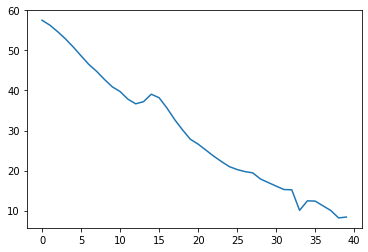

In [245]:
# sample every 7th sample 
# resampled_psd = 10*np.log10(np.square(decomp_signal_array[:,::7,:]))
resampled_psd = decomp_signal_array[:,::7,:]
db_psd = 10*np.log10(np.square(resampled_psd))
mean_psd = np.mean(a=db_psd,axis = 1)
mean_psd.shape

plt.plot(mean_psd[:,40])

In [177]:
# save as h5 file 
import os
directory, filename = os.path.split(filepath)
filename_no_ext, ext = os.path.splitext(filename)

#filename = filepath.split("/")[-1]
str1 = str(fileid)
str2 = '_ieeg_wavelet.h5'
h5_filename = ptID + '_' + str1 + str2
h5_filepath = '/userdata/aallawala/pain_data/stage0/%s/mood_biomarker/preproc_data/' % (ptID)
full_filename = h5_filepath + h5_filename
version = '1.0'
print(full_filename)

# save averaged data 


/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_924_ieeg_wavelet.h5


In [ ]:
timestamp_str = rec_timestamp.isoformat()

hf = h5py.File(full_filename, 'w')

hf.create_dataset('resampled_psd', data=resampled_psd)
hf.attrs['description'] = 'data preprocessed: notch filter, PSD computed, resampled timesamples in PSD'
hf.attrs['filename'] = filename
hf.attrs['srate_new'] = sfreq
hf.attrs['notch_freqs'] = notch_freqs
hf.attrs['freqs'] = freqs
hf.attrs['version'] = version
hf.attrs['ch_labels'] = ch_label
hf.attrs['PatientID'] = ptID
hf.attrs['num_ch'] = n_ch
hf.attrs['rec_timestamp'] = str(rec_timestamp.isoformat)
# get date
today_date = date.today()
date_string = today_date.strftime("%Y-%m-%d")
hf.attrs['date preprocessed'] = date_string

print('wavelet data saved')

In [231]:
# hf = h5py.File(full_filename, 'r')
# hf.attrs['ch_labels']

# ^ example loading of data. Can't list attrs for some reason.  

In [244]:
del full_filename 
del hf 


In [246]:
## save averaged data. 

#filename = filepath.split("/")[-1]
str1 = str(fileid)
str2 = '_ieeg_wavelet_mean.h5'
h5_filename = ptID + '_' + str1 + str2
h5_filepath = '/userdata/aallawala/pain_data/stage0/%s/mood_biomarker/preproc_data/' % (ptID)
full_filename = h5_filepath + h5_filename
version = '1.0'
print(full_filename)

hf = h5py.File(full_filename, 'w')
hf.create_dataset(name='mean_psd', data=mean_psd)

hf.attrs['filename'] = filename
hf.attrs['srate_new'] = sfreq
hf.attrs['freqs'] = freqs
hf.attrs['version'] = "v1.0"
hf.attrs['ch_labels'] = ch_label
hf.attrs['PatientID'] = ptID
hf.attrs['n_ch'] = n_ch
hf.attrs['fileid'] = fileid
hf.attrs['rec_timestamp'] = str(rec_timestamp.isoformat)
# get date
today_date = date.today()
date_string = today_date.strftime("%Y-%m-%d")
hf.attrs['date data processed'] = date_string
hf.close()
print('mean psd saved')

/userdata/aallawala/pain_data/stage0/RCS04/mood_biomarker/preproc_data/RCS04_924_ieeg_wavelet_mean.h5
mean psd saved


In [255]:
filepath = '/datastore_spirit/human/ChronicPain_NK/js_decoding/all_bipolar/RCS04/during_surv/fif/RCS04_869_eeg_raw.fif'
tmp = re.findall(r'\d+', filepath)
res = list(map(int, tmp))
res
# fileid = res[1]

[4, 4, 869]